Note
- [Colab Only] Means the associated cell is required only if you are running the model on Google Colaboratory

## Mount Drive [Colab Only]
Mount the google drive to access the dataset stored on drive.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%load_ext tensorboard


## Extract the Dataset

In [ ]:
import zipfile  # For faster extraction
dataset_path = "/gdrive/My Drive/BRATS2018/MICCAI_BraTS_2018_Data_Training.zip"  # Replace with your dataset path
zfile = zipfile.ZipFile(dataset_path)
zfile.extractall()

## Get required packages
- **SimpleITK**: For loading the dataset
- **[model.py](https://github.com/IAmSuyogJadhav/3d-mri-brain-tumor-segmentation-using-autoencoder-regularization/)**: The model from BRATS2018 winning paper

In [ ]:
!pip install simpleitk
!wget https://github.com/IAmSuyogJadhav/3d-mri-brain-tumor-segmentation-using-autoencoder-regularization/raw/master/model.py

--2020-01-31 14:53:22--  https://github.com/IAmSuyogJadhav/3d-mri-brain-tumor-segmentation-using-autoencoder-regularization/raw/master/model.py
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IAmSuyogJadhav/3d-mri-brain-tumor-segmentation-using-autoencoder-regularization/master/model.py [following]
--2020-01-31 14:53:22--  https://raw.githubusercontent.com/IAmSuyogJadhav/3d-mri-brain-tumor-segmentation-using-autoencoder-regularization/master/model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16490 (16K) [text/plain]
Saving to: ‘model.py.1’

model.py.1          100%[===================>]  16

## Imports and helper functions

In [ ]:
import SimpleITK as sitk  # For loading the dataset
import numpy as np  # For data manipulation
from model import build_model  # For creating the model
import glob  # For populating the list of files
from scipy.ndimage import zoom  # For resizing
import re  # For parsing the filenames (to know their modality)

In [ ]:
def read_img(img_path):
    """
    Reads a .nii.gz image and returns as a numpy array.
    """
    return sitk.GetArrayFromImage(sitk.ReadImage(img_path))

In [ ]:
def resize(img, shape, mode='constant', orig_shape=(155, 240, 240)):
    """
    Wrapper for scipy.ndimage.zoom suited for MRI images.
    """
    assert len(shape) == 3, "Can not have more than 3 dimensions"
    factors = (
        shape[0]/orig_shape[0],
        shape[1]/orig_shape[1], 
        shape[2]/orig_shape[2]
    )
    
    # Resize to the given shape
    return zoom(img, factors, mode=mode)


def preprocess(img, out_shape=None):
    """
    Preprocess the image.
    Just an example, you can add more preprocessing steps if you wish to.
    """
    if out_shape is not None:
        img = resize(img, out_shape, mode='constant')
    
    # Normalize the image
    mean = img.mean()
    std = img.std()
    return (img - mean) / std


def preprocess_label(img, out_shape=None, mode='nearest'):
    """
    Separates out the 3 labels from the segmentation provided, namely:
    GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2))
    and the necrotic and non-enhancing tumor core (NCR/NET — label 1)
    """
    ncr = img == 1  # Necrotic and Non-Enhancing Tumor (NCR/NET)
    ed = img == 2  # Peritumoral Edema (ED)
    et = img == 4  # GD-enhancing Tumor (ET)
    
    if out_shape is not None:
        ncr = resize(ncr, out_shape, mode=mode)
        ed = resize(ed, out_shape, mode=mode)
        et = resize(et, out_shape, mode=mode)

    return np.array([ncr, ed, et], dtype=np.uint8)
    

## Loading Data


In [ ]:
# Get a list of files for all modalities individually
t1 = glob.glob('*GG/*/*t1.nii.gz')
t2 = glob.glob('*GG/*/*t2.nii.gz')
flair = glob.glob('*GG/*/*flair.nii.gz')
t1ce = glob.glob('*GG/*/*t1ce.nii.gz')
seg = glob.glob('*GG/*/*seg.nii.gz')  # Ground Truth

In [ ]:
seg

['HGG/Brats18_TCIA02_370_1/Brats18_TCIA02_370_1_seg.nii.gz',
 'HGG/Brats18_CBICA_ABY_1/Brats18_CBICA_ABY_1_seg.nii.gz',
 'HGG/Brats18_TCIA02_473_1/Brats18_TCIA02_473_1_seg.nii.gz',
 'HGG/Brats18_CBICA_AAB_1/Brats18_CBICA_AAB_1_seg.nii.gz',
 'HGG/Brats18_CBICA_AMH_1/Brats18_CBICA_AMH_1_seg.nii.gz',
 'HGG/Brats18_CBICA_BHB_1/Brats18_CBICA_BHB_1_seg.nii.gz',
 'HGG/Brats18_CBICA_AOD_1/Brats18_CBICA_AOD_1_seg.nii.gz',
 'HGG/Brats18_TCIA03_121_1/Brats18_TCIA03_121_1_seg.nii.gz',
 'HGG/Brats18_TCIA05_444_1/Brats18_TCIA05_444_1_seg.nii.gz',
 'HGG/Brats18_TCIA02_117_1/Brats18_TCIA02_117_1_seg.nii.gz',
 'HGG/Brats18_TCIA01_378_1/Brats18_TCIA01_378_1_seg.nii.gz',
 'HGG/Brats18_CBICA_AXM_1/Brats18_CBICA_AXM_1_seg.nii.gz',
 'HGG/Brats18_CBICA_AXQ_1/Brats18_CBICA_AXQ_1_seg.nii.gz',
 'HGG/Brats18_CBICA_AQZ_1/Brats18_CBICA_AQZ_1_seg.nii.gz',
 'HGG/Brats18_TCIA03_265_1/Brats18_TCIA03_265_1_seg.nii.gz',
 'HGG/Brats18_CBICA_ABM_1/Brats18_CBICA_ABM_1_seg.nii.gz',
 'HGG/Brats18_TCIA02_314_1/Brats18_TCIA02_

In [ ]:
#seg = glob.glob('HGG/*/*seg.nii.gz')  # Ground Truth

In [ ]:
len(seg)

285

In [ ]:
seg

['HGG/Brats18_TCIA02_370_1/Brats18_TCIA02_370_1_seg.nii.gz',
 'HGG/Brats18_CBICA_ABY_1/Brats18_CBICA_ABY_1_seg.nii.gz',
 'HGG/Brats18_TCIA02_473_1/Brats18_TCIA02_473_1_seg.nii.gz',
 'HGG/Brats18_CBICA_AAB_1/Brats18_CBICA_AAB_1_seg.nii.gz',
 'HGG/Brats18_CBICA_AMH_1/Brats18_CBICA_AMH_1_seg.nii.gz',
 'HGG/Brats18_CBICA_BHB_1/Brats18_CBICA_BHB_1_seg.nii.gz',
 'HGG/Brats18_CBICA_AOD_1/Brats18_CBICA_AOD_1_seg.nii.gz',
 'HGG/Brats18_TCIA03_121_1/Brats18_TCIA03_121_1_seg.nii.gz',
 'HGG/Brats18_TCIA05_444_1/Brats18_TCIA05_444_1_seg.nii.gz',
 'HGG/Brats18_TCIA02_117_1/Brats18_TCIA02_117_1_seg.nii.gz',
 'HGG/Brats18_TCIA01_378_1/Brats18_TCIA01_378_1_seg.nii.gz',
 'HGG/Brats18_CBICA_AXM_1/Brats18_CBICA_AXM_1_seg.nii.gz',
 'HGG/Brats18_CBICA_AXQ_1/Brats18_CBICA_AXQ_1_seg.nii.gz',
 'HGG/Brats18_CBICA_AQZ_1/Brats18_CBICA_AQZ_1_seg.nii.gz',
 'HGG/Brats18_TCIA03_265_1/Brats18_TCIA03_265_1_seg.nii.gz',
 'HGG/Brats18_CBICA_ABM_1/Brats18_CBICA_ABM_1_seg.nii.gz',
 'HGG/Brats18_TCIA02_314_1/Brats18_TCIA02_

Parse all the filenames and create a dictionary for each patient with structure:

{<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'t1': _<path to t1 MRI file&gt;_,<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'t2': _<path to t2 MRI&gt;_,<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'flair': _<path to FLAIR MRI file&gt;_,<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'t1ce': _<path to t1ce MRI file&gt;_,<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'seg': _<path to Ground Truth file&gt;_,<br />
}<br />

In [ ]:
pat = re.compile('.*_(\w*)\.nii\.gz')

data_paths = [{
    pat.findall(item)[0]:item
    for item in items
}
for items in list(zip(t1, t2, t1ce, flair, seg))]

In [ ]:
data_paths

[{'flair': 'HGG/Brats18_TCIA02_370_1/Brats18_TCIA02_370_1_flair.nii.gz',
  'seg': 'HGG/Brats18_TCIA02_370_1/Brats18_TCIA02_370_1_seg.nii.gz',
  't1': 'HGG/Brats18_TCIA02_370_1/Brats18_TCIA02_370_1_t1.nii.gz',
  't1ce': 'HGG/Brats18_TCIA02_370_1/Brats18_TCIA02_370_1_t1ce.nii.gz',
  't2': 'HGG/Brats18_TCIA02_370_1/Brats18_TCIA02_370_1_t2.nii.gz'},
 {'flair': 'HGG/Brats18_CBICA_ABY_1/Brats18_CBICA_ABY_1_flair.nii.gz',
  'seg': 'HGG/Brats18_CBICA_ABY_1/Brats18_CBICA_ABY_1_seg.nii.gz',
  't1': 'HGG/Brats18_CBICA_ABY_1/Brats18_CBICA_ABY_1_t1.nii.gz',
  't1ce': 'HGG/Brats18_CBICA_ABY_1/Brats18_CBICA_ABY_1_t1ce.nii.gz',
  't2': 'HGG/Brats18_CBICA_ABY_1/Brats18_CBICA_ABY_1_t2.nii.gz'},
 {'flair': 'HGG/Brats18_TCIA02_473_1/Brats18_TCIA02_473_1_flair.nii.gz',
  'seg': 'HGG/Brats18_TCIA02_473_1/Brats18_TCIA02_473_1_seg.nii.gz',
  't1': 'HGG/Brats18_TCIA02_473_1/Brats18_TCIA02_473_1_t1.nii.gz',
  't1ce': 'HGG/Brats18_TCIA02_473_1/Brats18_TCIA02_473_1_t1ce.nii.gz',
  't2': 'HGG/Brats18_TCIA02_473_1/

In [ ]:
len(data_paths)

285

## Load the data in a Numpy array
Creating an empty Numpy array beforehand and then filling up the data helps you gauge beforehand if the data fits in your memory.



_Loading only the first 4 images here, to save time._

In [ ]:
input_shape = (4, 80, 96, 64)
output_channels = 3
data = np.empty((len(data_paths),) + input_shape, dtype=np.float32)
labels = np.empty((len(data_paths), output_channels) + input_shape[1:], dtype=np.uint8)

In [ ]:
import math

# Parameters for the progress bar
total = len(data_paths)
step = 25 / total

for i, imgs in enumerate(data_paths):
    try:
        data[i] = np.array([preprocess(read_img(imgs[m]), input_shape[1:]) for m in ['t1', 't2', 't1ce', 'flair']], dtype=np.float32)
        labels[i] = preprocess_label(read_img(imgs['seg']), input_shape[1:])[None, ...]
        
        # Print the progress bar
        print('\r' + f'Progress: '
            f"[{'=' * int((i+1) * step) + ' ' * (24 - int((i+1) * step))}]"
            f"({math.ceil((i+1) * 100 / (total))} %)",
            end='')
    except Exception as e:
        print(f'Something went wrong with {imgs["t1"]}, skipping...\n Exception:\n{str(e)}')
        continue

Progress: [=========================](100 %)

In [ ]:
seg[4]

'HGG/Brats18_CBICA_AMH_1/Brats18_CBICA_AMH_1_seg.nii.gz'

(240, 240)
[0 1]
1551


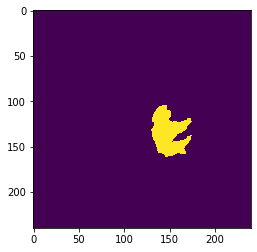

In [ ]:
import matplotlib.pyplot as plt
img = (read_img(seg[4])[100] == 2).astype(np.uint8)
#what is 100, why not 154, which is the lenght of read_img(seg[0])
print(img.shape)
print(np.unique(img))
print(img.sum())
img
#plt.imsave("first.jpg","/gdrive/My Drive")
plt.imshow(img)
#cv2_imshow(img)

## Model

build the model

In [ ]:
model = build_model(input_shape=input_shape, output_channels=3)

Train the model

In [ ]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
model.fit(data, labels, batch_size=1, epochs=1)

Epoch 1/1
285/285 [==============================] - 275s 965ms/step - loss: 0.2558 - dice_coefficient: 0.0053


That's it!

## Closing Regards

If you are resizing the segmentation mask, the resized segmentation mask retains the overall shape, but loses a lot of pixels and becomes somewhat 'grainy'. See the illustration below.

In [ ]:
from google.colab.patches import cv2_imshow
from PIL import Image

1. Original segmentation mask:

(240, 240)
[0 1]
1551


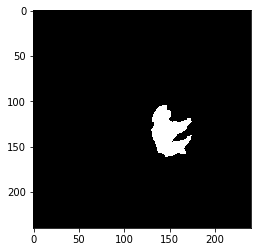

In [ ]:
import matplotlib.pyplot as plt
img = (read_img(seg[4])[100] == 2).astype(np.uint8)
#what is 100, why not 154, which is the lenght of read_img(seg[0])
print(img.shape)
print(np.unique(img))
print(img.sum())
img
#plt.imsave("first.jpg","/gdrive/My Drive")
plt.imshow(img, cmap='Greys_r')
#cv2_imshow(img)

In [ ]:
print(seg[0])

HGG/Brats18_TCIA02_370_1/Brats18_TCIA02_370_1_seg.nii.gz


In [ ]:
seg

['LGG/Brats18_TCIA10_629_1/Brats18_TCIA10_629_1_seg.nii.gz',
 'LGG/Brats18_TCIA10_442_1/Brats18_TCIA10_442_1_seg.nii.gz',
 'LGG/Brats18_TCIA10_276_1/Brats18_TCIA10_276_1_seg.nii.gz',
 'LGG/Brats18_TCIA10_632_1/Brats18_TCIA10_632_1_seg.nii.gz',
 'LGG/Brats18_TCIA13_654_1/Brats18_TCIA13_654_1_seg.nii.gz',
 'LGG/Brats18_TCIA09_312_1/Brats18_TCIA09_312_1_seg.nii.gz',
 'LGG/Brats18_TCIA10_299_1/Brats18_TCIA10_299_1_seg.nii.gz',
 'LGG/Brats18_2013_6_1/Brats18_2013_6_1_seg.nii.gz',
 'LGG/Brats18_TCIA10_625_1/Brats18_TCIA10_625_1_seg.nii.gz',
 'LGG/Brats18_TCIA10_202_1/Brats18_TCIA10_202_1_seg.nii.gz',
 'LGG/Brats18_TCIA10_640_1/Brats18_TCIA10_640_1_seg.nii.gz',
 'LGG/Brats18_TCIA10_413_1/Brats18_TCIA10_413_1_seg.nii.gz',
 'LGG/Brats18_TCIA09_255_1/Brats18_TCIA09_255_1_seg.nii.gz',
 'LGG/Brats18_TCIA13_615_1/Brats18_TCIA13_615_1_seg.nii.gz',
 'LGG/Brats18_TCIA10_628_1/Brats18_TCIA10_628_1_seg.nii.gz',
 'LGG/Brats18_TCIA09_177_1/Brats18_TCIA09_177_1_seg.nii.gz',
 'LGG/Brats18_TCIA09_451_1/Brats

In [ ]:
import matplotlib.pyplot as plt
for i in range(len(seg)):
  img = (read_img(seg[i])[100] == 2).astype(np.uint8)
  #what is 100, why not 154, which is the lenght of read_img(seg[0])
  # print(img.shape)
  # print(np.unique(img))
  # print(img.sum())
  # img
  plt.imsave("/gdrive/My Drive/SEG/{}.jpg".format(i), img)
  # plt.imshow(img, cmap='Greys_r')
#cv2_imshow(img)

In [ ]:
import matplotlib.pyplot as plt
for i in range(len(t1)):
  img = (read_img(t1[i])[100] == 2).astype(np.uint8)
  #what is 100, why not 154, which is the lenght of read_img(seg[0])
  # print(img.shape)
  # print(np.unique(img))
  # print(img.sum())
  # img
  plt.imsave("/gdrive/My Drive/t1/{}.jpg".format(i), img)
  # plt.imshow(img, cmap='Greys_r')
#cv2_imshow(img)

In [ ]:
import matplotlib.pyplot as plt
for i in range(len(t2)):
  img = (read_img(t2[i])[100] == 2).astype(np.uint8)
  #what is 100, why not 154, which is the lenght of read_img(seg[0])
  # print(img.shape)
  # print(np.unique(img))
  # print(img.sum())
  # img
  plt.imsave("/gdrive/My Drive/t2/{}.jpg".format(i), img)
  # plt.imshow(img, cmap='Greys_r')
#cv2_imshow(img)

In [ ]:
import matplotlib.pyplot as plt
for i in range(len(flair)):
  img = (read_img(flair[i])[100] == 2).astype(np.uint8)
  #what is 100, why not 154, which is the lenght of read_img(seg[0])
  # print(img.shape)
  # print(np.unique(img))
  # print(img.sum())
  # img
  plt.imsave("/gdrive/My Drive/flair/{}.jpg".format(i), img)
  # plt.imshow(img, cmap='Greys_r')
#cv2_imshow(img)

In [ ]:
import matplotlib.pyplot as plt
for i in range(len(t1ce)):
  img = (read_img(t1ce[i])[100] == 2).astype(np.uint8)
  #what is 100, why not 154, which is the lenght of read_img(seg[0])
  # print(img.shape)
  # print(np.unique(img))
  # print(img.sum())
  # img
  plt.imsave("/gdrive/My Drive/t1ce/{}.jpg".format(i), img)
  # plt.imshow(img, cmap='Greys_r')
#cv2_imshow(img)

In [ ]:
img = PIL.Image.fromarray(img)

In [ ]:
type(img)
img.show()

In [ ]:
read_img(seg[0])

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [ ]:
new_im = Image.fromarray(img)
new_im.save("numpy_altered_sample2.png")


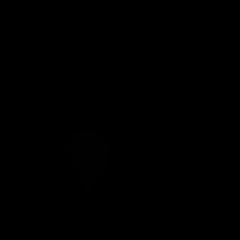

In [ ]:
new_im

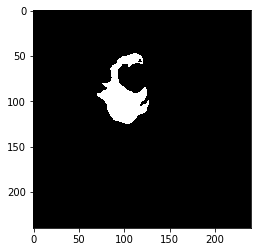

In [ ]:
for i in range(3):
  img = (read_img(seg[i])[100] == 2).astype(np.uint8)
plt.imshow(img, cmap='Greys_r')

In [ ]:
img = (read_img(seg[0])[100] == 2).astype(np.uint8)

In [ ]:
len(read_img(seg[0]))

155

(240, 240)
[0]
0


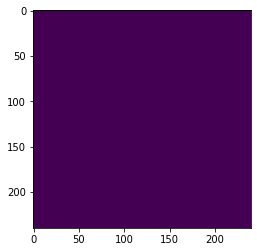

In [ ]:
import matplotlib.pyplot as plt
img = (read_img(t1[0])[100] == 2).astype(np.uint8)
#what is 100, why not 154
print(img.shape)
print(np.unique(img))
print(img.sum())
plt.imshow(img)

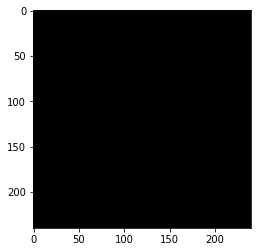

In [ ]:
plt.imshow(img, cmap='Greys_r')

After resizing to (80, 96, 64)

(96, 64)
[0 1]
20


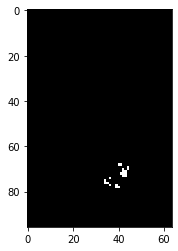

In [ ]:
img = preprocess_label(read_img(seg[0]), out_shape=(80, 96, 64), mode='nearest')[1][50]
print(img.shape)
print(np.unique(img))
print(img.sum())
plt.imshow(img, cmap='Greys_r')

One can clearly notice that there are now a lot of black pixels in the region where there should have been only white pixels. This can potentially hurt our model. So, it is best to not resize the image too much. But, due to computational constraints and the model requirements, it is unavoidable. 

However, given below are a few things one could try to reduce the downsampling noise as much as possible.

In [ ]:
import cv2

- Original Image > preprocess_label > Morphological Closing

[0 1]
50


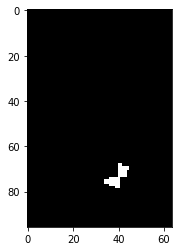

In [ ]:
kernel = np.ones((3, 3))
img_closed = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)
print(np.unique(img_closed))
print(img_closed.sum())
plt.imshow(img_closed, cmap='Greys_r')

- Original Image > preprocess_label > Morphological Dilation

[0 1]
84


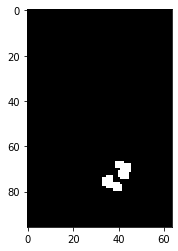

In [ ]:
kernel = np.ones((3, 3))
img_dilated = cv2.dilate(img, kernel, iterations=1)
print(np.unique(img_dilated))
print(img_dilated.sum())
plt.imshow(img_dilated, cmap='Greys_r')

You could try these things to get even better results.

## Feedback

If you have any feedback, queries, bug reports to send, please feel free to [raise an issue](https://github.com/IAmSuyogJadhav/3d-mri-brain-tumor-segmentation-using-autoencoder-regularization/issues/new) on github. It would be really helpful!